In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [8]:
# Load and preprocess data
def load_data(file_path, num_rows=20000):
    data = pd.read_csv(file_path, sep='\s+', header=None,
                       names=['Date', 'Time', 'Sensor', 'State'])
    data = data.iloc[:num_rows,:]
    data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%Y-%m-%d %H:%M:%S.%f')
    return data

In [9]:
# Function to create sequences
def create_sequences(df, sequence_length=60):
    sequences = []
    for i in range(len(df) - sequence_length):
        # The 'DateTime' column is already removed, no need to drop it here.
        sequence = df.iloc[i:i+sequence_length].values
        sequences.append(sequence)
    return np.array(sequences)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Load normal data (after mounting)
normal_data = load_data(file_path='/content/drive/MyDrive/Copy of aruba.20100217-20240201_20240625.181859.txt') # Make sure this path is correct



Mounted at /content/drive


In [12]:
normal_data

,Date,Time,Sensor,State,DateTime
0,2010-10-13,16:53:58.648634,M022,OFF,2010-10-13 16:53:58.648634
1,2010-10-13,16:53:58.674960,M030,OFF,2010-10-13 16:53:58.674960
2,2010-10-13,16:53:58.701451,M001,OFF,2010-10-13 16:53:58.701451
3,2010-10-13,16:53:58.731156,D001,CLOSE,2010-10-13 16:53:58.731156
4,2010-10-13,16:53:58.756695,D004,CLOSE,2010-10-13 16:53:58.756695
...,...,...,...,...,...
19995,2010-10-14,18:58:28.179230,M019,ON,2010-10-14 18:58:28.179230
19996,2010-10-14,18:58:30.651351,M019,OFF,2010-10-14 18:58:30.651351
19997,2010-10-14,18:58:31.275414,M019,ON,2010-10-14 18:58:31.275414
19998,2010-10-14,18:58:39.126688,M019,OFF,2010-10-14 18:58:39.126688


In [16]:
normal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      20000 non-null  object        
 1   Time      20000 non-null  object        
 2   Sensor    20000 non-null  object        
 3   State     20000 non-null  object        
 4   DateTime  20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 781.4+ KB


In [15]:
normal_data.Sensor.value_counts()

,count
Sensor,
M019,3197
M015,2703
M014,1459
M020,1322
M018,1247
M017,1077
M024,933
M009,835
M010,769


In [17]:
# Define a dictionary to map sensor IDs to proper names
sensor_names = {
    'M019': 'Kitchen_MotionSensor_019',
    'M015': 'Dining_MotionSensor_015',
    'M014': 'LivingRoom_MotionSensor_014',
    'M020': 'Bedroom_MotionSensor_020',
    'M018': 'Bathroom_MotionSensor_018',
    'M017': 'Office_MotionSensor_017',
    'M024': 'Garage_MotionSensor_024',
    'M009': 'Kitchen_MotionSensor_009',
    'M010': 'Dining_MotionSensor_010',
    'M021': 'LivingRoom_MotionSensor_021',
    'M016': 'Bedroom_MotionSensor_016',
    'M022': 'Bathroom_MotionSensor_022',
    'M007': 'Office_MotionSensor_007',
    'M023': 'Garage_MotionSensor_023',
    'M013': 'Kitchen_MotionSensor_013',
    'M008': 'Dining_MotionSensor_008',
    'M027': 'LivingRoom_MotionSensor_027',
    'M006': 'Bedroom_MotionSensor_006',
    'M029': 'Bathroom_MotionSensor_029',
    'M028': 'Office_MotionSensor_028',
    'M005': 'Garage_MotionSensor_005',
    'M003': 'Kitchen_MotionSensor_003',
    'M026': 'Dining_MotionSensor_026',
    'M012': 'LivingRoom_MotionSensor_012',
    'M004': 'Bedroom_MotionSensor_004',
    'M030': 'Bathroom_MotionSensor_030',
    'D004': 'Garage_DoorSensor_004',
    'M025': 'Office_MotionSensor_025',
    'M001': 'Kitchen_MotionSensor_001',
    'M031': 'Dining_MotionSensor_031',
    'M002': 'LivingRoom_MotionSensor_002',
    'M011': 'Bedroom_MotionSensor_011',
    'D001': 'Bathroom_DoorSensor_001',
    'D002': 'Office_DoorSensor_002'
}

# Assign proper names to a new column
normal_data['Sensor_Name'] = normal_data['Sensor'].map(sensor_names)


In [18]:
normal_data


,Date,Time,Sensor,State,DateTime,Sensor_Name
0,2010-10-13,16:53:58.648634,M022,OFF,2010-10-13 16:53:58.648634,Bathroom_MotionSensor_022
1,2010-10-13,16:53:58.674960,M030,OFF,2010-10-13 16:53:58.674960,Bathroom_MotionSensor_030
2,2010-10-13,16:53:58.701451,M001,OFF,2010-10-13 16:53:58.701451,Kitchen_MotionSensor_001
3,2010-10-13,16:53:58.731156,D001,CLOSE,2010-10-13 16:53:58.731156,Bathroom_DoorSensor_001
4,2010-10-13,16:53:58.756695,D004,CLOSE,2010-10-13 16:53:58.756695,Garage_DoorSensor_004
...,...,...,...,...,...,...
19995,2010-10-14,18:58:28.179230,M019,ON,2010-10-14 18:58:28.179230,Kitchen_MotionSensor_019
19996,2010-10-14,18:58:30.651351,M019,OFF,2010-10-14 18:58:30.651351,Kitchen_MotionSensor_019
19997,2010-10-14,18:58:31.275414,M019,ON,2010-10-14 18:58:31.275414,Kitchen_MotionSensor_019
19998,2010-10-14,18:58:39.126688,M019,OFF,2010-10-14 18:58:39.126688,Kitchen_MotionSensor_019


M019: Kitchen_MotionSensor_019
M015: Dining_MotionSensor_015
M014: LivingRoom_MotionSensor_014
M020: Bedroom_MotionSensor_020
M018: Bathroom_MotionSensor_018
M017: Office_MotionSensor_017
M024: Garage_MotionSensor_024
M009: Kitchen_MotionSensor_009
M010: Dining_MotionSensor_010
M021: LivingRoom_MotionSensor_021
M016: Bedroom_MotionSensor_016
M022: Bathroom_MotionSensor_022
M007: Office_MotionSensor_007
M023: Garage_MotionSensor_023
M013: Kitchen_MotionSensor_013
M008: Dining_MotionSensor_008
M027: LivingRoom_MotionSensor_027
M006: Bedroom_MotionSensor_006
M029: Bathroom_MotionSensor_029
M028: Office_MotionSensor_028
M005: Garage_MotionSensor_005
M003: Kitchen_MotionSensor_003
M026: Dining_MotionSensor_026
M012: LivingRoom_MotionSensor_012
M004: Bedroom_MotionSensor_004
M030: Bathroom_MotionSensor_030
D004: Garage_DoorSensor_004
M025: Office_MotionSensor_025
M001: Kitchen_MotionSensor_001
M031: Dining_MotionSensor_031
M002: LivingRoom_MotionSensor_002
M011: Bedroom_MotionSensor_011
D001: Bathroom_DoorSensor_001
D002: Office_DoorSensor_002

In [19]:
# Define actions based on sensor sequences
def label_actions(df):
    actions = []
    for i in range(len(df) - 1):
        if df.iloc[i]['Sensor_Name'].startswith('Kitchen') and df.iloc[i+1]['Sensor_Name'].startswith('Kitchen'):
            actions.append('In Kitchen')
        elif df.iloc[i]['Sensor_Name'].startswith('Dining') and df.iloc[i+1]['Sensor_Name'].startswith('Dining'):
            actions.append('In Dining Room')
        elif df.iloc[i]['Sensor_Name'].startswith('LivingRoom') and df.iloc[i+1]['Sensor_Name'].startswith('LivingRoom'):
            actions.append('In Living Room')
        elif df.iloc[i]['Sensor_Name'].startswith('Bedroom') and df.iloc[i+1]['Sensor_Name'].startswith('Bedroom'):
            actions.append('In Bedroom')
        elif df.iloc[i]['Sensor_Name'].startswith('Bathroom') and df.iloc[i+1]['Sensor_Name'].startswith('Bathroom'):
            actions.append('In Bathroom')
        elif df.iloc[i]['Sensor_Name'].startswith('Office') and df.iloc[i+1]['Sensor_Name'].startswith('Office'):
            actions.append('In Office')
        elif df.iloc[i]['Sensor_Name'].startswith('Garage') and df.iloc[i+1]['Sensor_Name'].startswith('Garage'):
            actions.append('In Garage')
        else:
            actions.append('Moving')
    actions.append('No Action')  # For the last row
    return actions

# Apply the function to label actions
normal_data['Action'] = label_actions(normal_data)



## actions:

In [20]:
normal_data

,Date,Time,Sensor,State,DateTime,Sensor_Name,Action
0,2010-10-13,16:53:58.648634,M022,OFF,2010-10-13 16:53:58.648634,Bathroom_MotionSensor_022,In Bathroom
1,2010-10-13,16:53:58.674960,M030,OFF,2010-10-13 16:53:58.674960,Bathroom_MotionSensor_030,Moving
2,2010-10-13,16:53:58.701451,M001,OFF,2010-10-13 16:53:58.701451,Kitchen_MotionSensor_001,Moving
3,2010-10-13,16:53:58.731156,D001,CLOSE,2010-10-13 16:53:58.731156,Bathroom_DoorSensor_001,Moving
4,2010-10-13,16:53:58.756695,D004,CLOSE,2010-10-13 16:53:58.756695,Garage_DoorSensor_004,Moving
...,...,...,...,...,...,...,...
19995,2010-10-14,18:58:28.179230,M019,ON,2010-10-14 18:58:28.179230,Kitchen_MotionSensor_019,In Kitchen
19996,2010-10-14,18:58:30.651351,M019,OFF,2010-10-14 18:58:30.651351,Kitchen_MotionSensor_019,In Kitchen
19997,2010-10-14,18:58:31.275414,M019,ON,2010-10-14 18:58:31.275414,Kitchen_MotionSensor_019,In Kitchen
19998,2010-10-14,18:58:39.126688,M019,OFF,2010-10-14 18:58:39.126688,Kitchen_MotionSensor_019,Moving


In [ ]:
# Combine and preprocess data
combined_data = pd.get_dummies(normal_data, columns=['Sensor', 'State'])
combined_data = combined_data.drop(columns=['DateTime', 'Time', 'Date'])

In [ ]:
# Create sequences
X = create_sequences(combined_data)

In [ ]:
X.shape

(19940, 60, 38)

In [ ]:
# Train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
# Convert data types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


In [ ]:
model = Sequential([
    LSTM(100, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(100, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0372 - val_loss: 0.0345
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.0345 - val_loss: 0.0343
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0343 - val_loss: 0.0341
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0341 - val_loss: 0.0339
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0338 - val_loss: 0.0335
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0334 - val_loss: 0.0333
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0334 - val_loss: 0.0331
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0332 - val_loss: 0.0330
Epoch 9/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0330 - val_loss: 0.0329
Epoch 10/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0329 - val_loss: 0.0327


In [ ]:
# Evaluate the model
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reshape predictions and true values if necessary
X_train_pred = X_train_pred.reshape(-1, X_train.shape[2])
X_test_pred = X_test_pred.reshape(-1, X_test.shape[2])
X_train_true = X_train.reshape(-1, X_train.shape[2])
X_test_true = X_test.reshape(-1, X_test.shape[2])

# Calculate metrics
train_mae = mean_absolute_error(X_train_true, X_train_pred)
train_mse = mean_squared_error(X_train_true, X_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(X_train_true, X_train_pred)

test_mae = mean_absolute_error(X_test_true, X_test_pred)
test_mse = mean_squared_error(X_test_true, X_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(X_test_true, X_test_pred)

# Print the evaluation results
print(f"Training MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
print(f"Testing MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

Training MAE: 0.0709, MSE: 0.0327, RMSE: 0.1809, R²: 0.1154
Testing MAE: 0.0710, MSE: 0.0328, RMSE: 0.1810, R²: 0.1115


## a new approach

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [ ]:
# Load and preprocess data
def load_data(file_path, num_rows=20000):
    data = pd.read_csv(file_path, sep='\s+', header=None,
                       names=['Date', 'Time', 'Sensor', 'State'])
    data = data.iloc[:num_rows,:]
    data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%Y-%m-%d %H:%M:%S.%f')
    return data


In [ ]:
# Function to create sequences
def create_sequences(df, sequence_length=60):
    sequences = []
    for i in range(len(df) - sequence_length):
        sequence = df.iloc[i:i+sequence_length].values
        sequences.append(sequence)
    return np.array(sequences)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Load normal data (after mounting)
# normal_data = load_data(file_path='/content/drive/MyDrive/Copy of aruba.20100217-20240201_20240625.181859.txt') # Make sure this path is correct

# |

SyntaxError: invalid syntax (<ipython-input-13-0a9cfe550110>, line 7)

In [ ]:
# Combine and preprocess data
combined_data = pd.get_dummies(normal_data, columns=['Sensor', 'State'])
combined_data = combined_data.drop(columns=['DateTime', 'Time', 'Date'])


In [ ]:
# Create sequences
X = create_sequences(combined_data)


In [ ]:
# Train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


In [ ]:
# Convert data types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(100, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(100, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')


In [ ]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0370 - val_loss: 0.0345
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0344 - val_loss: 0.0342
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0343 - val_loss: 0.0342
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0342 - val_loss: 0.0340
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0340 - val_loss: 0.0336
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0337 - val_loss: 0.0334
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0335 - val_loss: 0.0331
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0332 - val_loss: 0.0329
Epoch 9/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0330 - val_loss: 0.0328
Epoch 10/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0329 - val_loss: 0.0327


In [ ]:
# Evaluate the model on training and testing data
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)


499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# Calculate reconstruction error and set a threshold for anomaly detection
train_mse = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))
test_mse = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))


In [ ]:
# Set a threshold for anomaly detection
threshold = np.percentile(train_mse, 100)  # Adjust the percentile as needed


In [ ]:
# Generate labels based on the reconstruction error
train_labels = (train_mse > threshold).astype(int)
test_labels = (test_mse > threshold).astype(int)


In [ ]:
# Print the results
print(f"Threshold for anomaly detection: {threshold:.4f}")
print(f"Training anomalies detected: {np.sum(train_labels)}")
print(f"Testing anomalies detected: {np.sum(test_labels)}")


Threshold for anomaly detection: 0.0398
Training anomalies detected: 0
Testing anomalies detected: 0


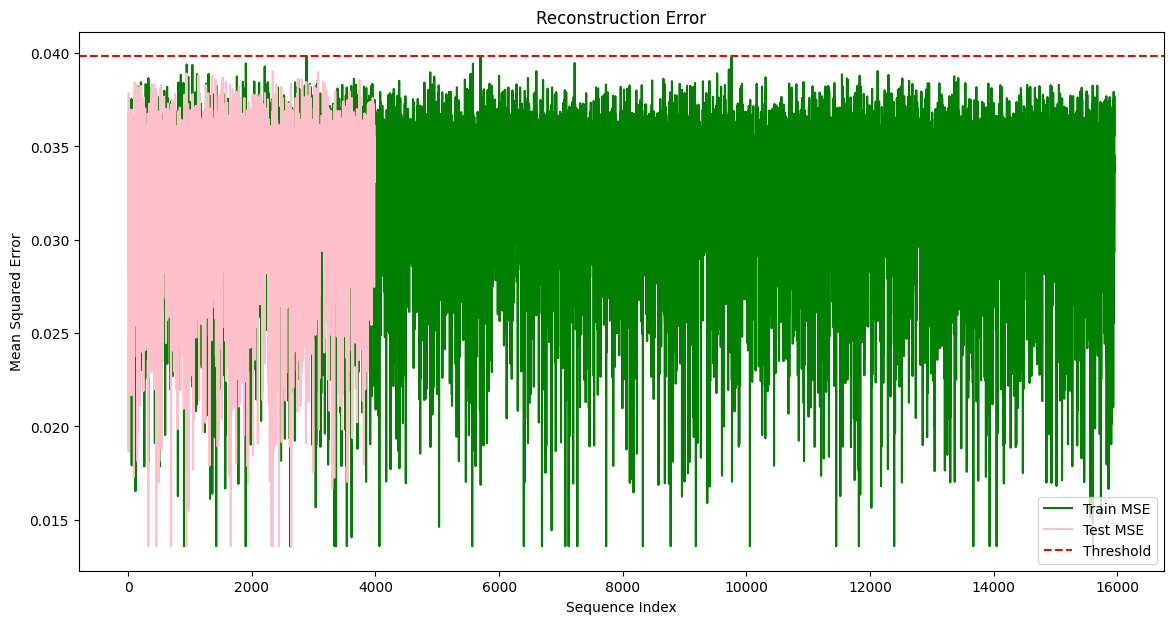

In [ ]:
# Visualize the reconstruction errors
plt.figure(figsize=(14, 7))
plt.plot(train_mse, label='Train MSE', color='green')
plt.plot(test_mse, label='Test MSE', color='pink')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error')
plt.xlabel('Sequence Index')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()